In [2]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms


In [3]:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]


In [4]:
transform = transforms.ToTensor()

dataset = CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

print("Total images:", len(dataset))


100%|██████████| 170M/170M [00:03<00:00, 48.7MB/s] 


Total images: 50000


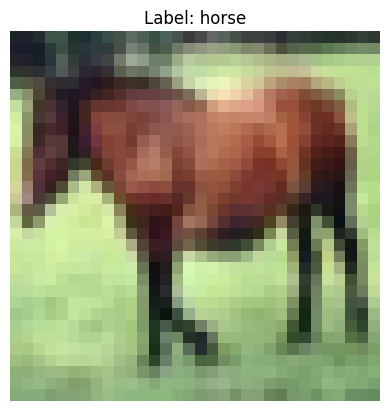

In [5]:
idx = 7  # try changing this number
img, label = dataset[idx]

plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Label: {class_names[label]}")
plt.show()


In [6]:
import torchvision.transforms as T
from torch.utils.data import DataLoader


In [7]:
class SSLTransform:
    def __init__(self):
        self.transform = T.Compose([
            T.RandomResizedCrop(32, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.4, 0.4, 0.4, 0.1),
            T.ToTensor()
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)


In [8]:
ssl_dataset = CIFAR10(
    root="./data",
    train=True,
    download=False,
    transform=SSLTransform()
)


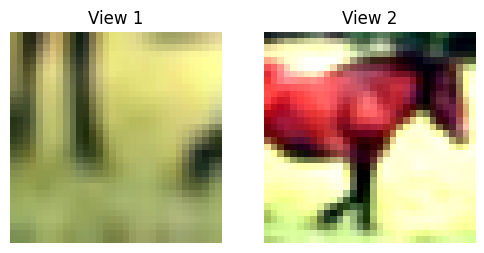

In [9]:
(view1, view2), _ = ssl_dataset[7]

fig, axes = plt.subplots(1, 2, figsize=(6,3))
axes[0].imshow(view1.permute(1,2,0))
axes[0].set_title("View 1")
axes[1].imshow(view2.permute(1,2,0))
axes[1].set_title("View 2")

for ax in axes:
    ax.axis("off")

plt.show()


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

torch.manual_seed(42)


Using device: cuda


In [12]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet18(pretrained=False)
        self.features = nn.Sequential(*list(backbone.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x


In [13]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=512, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(),
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [14]:
class SSLModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.projector = ProjectionHead()

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return h, z


In [15]:
model = SSLModel().to(device)
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SSLModel(
  (encoder): Encoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-

In [16]:
ssl_loader = DataLoader(
    ssl_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    drop_last=True
)


In [17]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)

        batch_size = z1.size(0)
        z = torch.cat([z1, z2], dim=0)

        sim = torch.matmul(z, z.T) / self.temperature
        mask = torch.eye(2 * batch_size, device=sim.device).bool()
        sim.masked_fill_(mask, -9e15)

        pos = torch.cat([
            torch.diag(sim, batch_size),
            torch.diag(sim, -batch_size)
        ])

        loss = -pos + torch.logsumexp(sim, dim=1)
        return loss.mean()


In [18]:
criterion = NTXentLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

def train_ssl(model, loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for (x1, x2), _ in loader:
            x1 = x1.to(device)
            x2 = x2.to(device)

            _, z1 = model(x1)
            _, z2 = model(x2)

            loss = criterion(z1, z2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss = {total_loss/len(loader):.4f}")


In [19]:
train_ssl(model, ssl_loader, epochs=10)


Epoch 1: Loss = 5.2194
Epoch 2: Loss = 5.0319
Epoch 3: Loss = 4.9634
Epoch 4: Loss = 4.9150
Epoch 5: Loss = 4.8860
Epoch 6: Loss = 4.8695
Epoch 7: Loss = 4.8444
Epoch 8: Loss = 4.8302
Epoch 9: Loss = 4.8211
Epoch 10: Loss = 4.8104


In [20]:
for param in model.encoder.parameters():
    param.requires_grad = False

print("Encoder frozen.")


Encoder frozen.


In [21]:
class LinearClassifier(nn.Module):
    def __init__(self, in_dim=512, num_classes=10):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        return self.fc(x)


In [22]:
from torch.utils.data import DataLoader

supervised_dataset = CIFAR10(
    root="./data",
    train=True,
    download=False,
    transform=T.ToTensor()
)

supervised_loader = DataLoader(
    supervised_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=2
)


In [23]:
classifier = LinearClassifier().to(device)

criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=1e-3)

def train_classifier(encoder, classifier, loader, epochs=5):
    encoder.eval()
    classifier.train()

    for epoch in range(epochs):
        correct, total, total_loss = 0, 0, 0

        for x, y in loader:
            x, y = x.to(device), y.to(device)

            with torch.no_grad():
                features = encoder(x)

            logits = classifier(features)
            loss = criterion_cls(logits, y)

            optimizer_cls.zero_grad()
            loss.backward()
            optimizer_cls.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        acc = 100 * correct / total
        print(f"Epoch {epoch+1}: Loss={total_loss/len(loader):.4f}, Acc={acc:.2f}%")


In [24]:
train_classifier(
    model.encoder,
    classifier,
    supervised_loader,
    epochs=5
)


Epoch 1: Loss=1.5726, Acc=42.24%
Epoch 2: Loss=1.4593, Acc=46.48%
Epoch 3: Loss=1.4316, Acc=47.71%
Epoch 4: Loss=1.4152, Acc=48.35%
Epoch 5: Loss=1.3991, Acc=48.95%


In [25]:
from PIL import Image
import torchvision.transforms as transforms



In [26]:
upload_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])


In [27]:
def interactive_predict_uploaded_image():
    path = input("Enter path to image file: ")

    try:
        img = Image.open(path).convert("RGB")
    except:
        print("❌ Could not open image. Check the path.")
        return

    # show uploaded image
    plt.imshow(img)
    plt.axis("off")
    plt.title("Uploaded Image")
    plt.show()

    # preprocess image
    x = upload_transform(img).unsqueeze(0).to(device)

    # prediction
    model.encoder.eval()
    classifier.eval()

    with torch.no_grad():
        features = model.encoder(x)
        logits = classifier(features)

        # safety for single image
        if logits.dim() == 1:
            logits = logits.unsqueeze(0)

        probs = torch.softmax(logits, dim=1)
        pred = probs.argmax(dim=1).item()
        confidence = probs.max().item()

    topk = torch.topk(probs, k=3)

    print("🔮 Model Prediction (Top-3)")
    for i in range(3):
        cls = class_names[topk.indices[0][i].item()]
        conf = topk.values[0][i].item()
        print(f"{i+1}. {cls} ({conf:.2f})")

    if confidence < 0.5:
        print("⚠️ Low confidence → image may be out of training distribution")





   

Enter path to image file:  /kaggle/input/cat-data/cat.jpeg


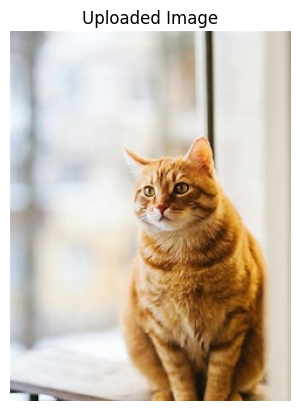

🔮 Model Prediction (Top-3)
1. bird (0.39)
2. cat (0.21)
3. dog (0.18)
⚠️ Low confidence → image may be out of training distribution


In [34]:
interactive_predict_uploaded_image()
